# Estimacion de categorias - Pagina12

In [1]:
# Instalacion de Bibliotecas
!pip install gdown --quiet

In [ ]:
# Importo bibliotecas
import gdown
import sys
import warnings
import pprint
import gc
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Descargo punkt
nltk.download('punkt')

# PrettyPrinter
pp = pprint.PrettyPrinter(indent=4, compact=True)

# Libero memoria
gc.collect()

# No mostrar warnings
warnings.filterwarnings('ignore')

# Limite de recursion
sys.setrecursionlimit(30000)

# Tema de graficos
sns.set_theme(style="whitegrid")

In [3]:
# Descargo datasets de secciones de noticias
gdown.download('https://drive.google.com/uc?id=1qLM1mV45A9-hUI9dWb4SwtqCmfmAA35R', 'Sociedad.sav', quiet=False)
gdown.download('https://drive.google.com/uc?id=19KLD-8nRba8XWwcw6YjChwB4KSZ10g6v', 'Economia.sav', quiet=False)
gdown.download('https://drive.google.com/uc?id=1juCpm4wAXHFXH3IBVQ3FrkfQ7I8r9BLn', 'ElMundo.sav', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1qLM1mV45A9-hUI9dWb4SwtqCmfmAA35R
To: /content/Sociedad.sav
824MB [00:04, 174MB/s]
839MB [00:20, 41.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1juCpm4wAXHFXH3IBVQ3FrkfQ7I8r9BLn
To: /content/ElMundo.sav
814MB [00:12, 63.7MB/s]


'ElMundo.sav'

In [4]:
# Cargo secciones (Aproximadamente toma 5 minutos en cargar las tres secciones)
society_section = joblib.load('Sociedad.sav')
economy_section = joblib.load('Economia.sav')
world_section = joblib.load('ElMundo.sav')

In [5]:
# Concatenamos secciones
news = pd.concat([society_section, economy_section, world_section], axis=0)

In [6]:
# Imprimo tamanios de los conjuntos de datos
pp.pprint("Tamaño de secciones:")
pp.pprint(f"Sociedad: {society_section.shape[0]}")
pp.pprint(f"Economia: {economy_section.shape[0]}")
pp.pprint(f"El-Mundo: {world_section.shape[0]}")
pp.pprint(f"Total: {news.shape[0]}")

'Tamaño de secciones:'
'Sociedad: 1005'
'Economia: 1093'
'El-Mundo: 993'
'Total: 3091'


In [ ]:
# Borramos temporal de secciones
del society_section
del economy_section
del world_section

# Libero memoria
gc.collect()

In [8]:
# Cargamos stopwords
stopwords_es = pd.read_csv('https://drive.google.com/uc?export=download&id=1prdR9zCvSQnEIZoLf5B0TiS1tUhMLClC', header = None)
stopwords_es_sin_acentos = pd.read_csv('https://drive.google.com/uc?export=download&id=1QDLZXPDnJ1XbHJRukDgqxi5P0AKtssd_', header = None)

stopwords = pd.concat([stopwords_es, stopwords_es_sin_acentos])

In [9]:
def remove_stop_words(text):
  """
    Remueve stop words en inglés

    Attributes
    ----------
    text: list
      lista de palabras (tokens) a filtrar

    Returns
    -------
    list
      lista de palabras sin los stop words
  """
  return [token for token in text if token.lower() not in stopwords]

In [13]:
def stem_words(tokens):
  """
    Transforma mediante un stemmer a una secuencia de tokens.

    Attributes
    ----------
    tokens: list
      secuencia de tokens.

    Returns
    -------
    list
      secuencia de tokens stemmerizados
  """
  stemmer = SnowballStemmer("spanish")
  return [stemmer.stem(word) for word in tokens]

In [11]:
def clean_short_words(text):
  """
    Limpia palabras con longitud 1

    Attributes
    ----------
    text: str
      documento a tokenizar
    
    Returns
    -------
    list
      lista de tokens
  """
  return [word for word in text if len(word) > 1]

In [87]:
def preprocess_text(text):
  """
    Pre-procesamiento

    Attributes
    ----------
    text: str
      documento a analizar

    Returns
    -------
    pd.DataFrame
      retorna un dataframe con las 20 palabras que más se repiten y su frecuencia
  """
  tokenized_words = word_tokenize(text, language='spanish')
  words_without_stops = remove_stop_words(tokenized_words)
  without_short_words = clean_short_words(words_without_stops)
  stemmed_words = stem_words(without_short_words)
  return stemmed_words

In [15]:
def create_train_test_csv(X_train, X_test, y_train, y_test):
  """
    Crea archivos csv de datasets de entrenamiento y prueba

    Attributes
    ----------
    X_train: Pandas Dataframe
      predictoras del conjunto de entrenamiento

    X_test: Pandas Dataframe
      predictoras del conjunto de prueba

    y_train: Pandas Dataframe
      valores del target del conjunto de entrenamiento

    y_test: Pandas Dataframe
      valores del target del conjunto de prueba
  """
  train_dataset = pd.concat([X_train, y_train], axis=1)
  test_dataset = pd.concat([X_test, y_test], axis=1)
  
  train_dataset[train_dataset.topic == 'sociedad'].to_csv('Sociedad_Training.csv', sep='\t', encoding='utf-8')
  test_dataset[test_dataset.topic == 'sociedad'].to_csv('Sociedad_Testing.csv', sep='\t', encoding='utf-8')

  train_dataset[train_dataset.topic == 'el-mundo'].to_csv('ElMundo_Training.csv', sep='\t', encoding='utf-8')
  test_dataset[test_dataset.topic == 'el-mundo'].to_csv('ElMundo_Testing.csv', sep='\t', encoding='utf-8')

  train_dataset[train_dataset.topic == 'economia'].to_csv('Economia_Training.csv', sep='\t', encoding='utf-8')
  test_dataset[test_dataset.topic == 'economia'].to_csv('Economia_Testing.csv', sep='\t', encoding='utf-8')

In [65]:
def convert_spanish_months_to_number(dates):
  """
    Convierte meses en espaniol a numeros de los meses para unas fechas determinadas

    Attributes
    ----------
    dates: Pandas Series
      serie de Pandas conteniendo las fechas

    Returns
    -------
    list
      retorna una lista con las nuevas fechas formateadas
  """
  formatted_dates = []
  month_numbers = dict({'enero':'01', 'febrero':'02', 'marzo':'03', 'abril':'04', 
                        'mayo':'05', 'junio':'06', 'julio':'07', 'agosto':'08', 
                        'septiembre':'09', 'octubre':'10', 'noviembre':'11', 'diciembre':'12'})

  for date in dates:
    formatted_date = ' '.join([month_numbers.get(date_word, date_word) for date_word in date.split()])
    formatted_dates.append(formatted_date)

  return formatted_dates

In [ ]:
# Observamos el dataset antes de ordenar
news.head()

In [ ]:
# Convertimos meses de espaniol a numeros
news['date'] = convert_spanish_months_to_number(news['date'])

# Convertimos string a formato fecha
news['date'] = pd.to_datetime(news['date'], format='%d de %m de %Y - %H:%M')

# Ordenamos dataset segun fecha
news.sort_values(by='date', inplace=True)

# Observamos como quedo el dataset ordenado
news.head()

In [ ]:
# Separacion en entrenamiento y validacion
X_train, X_test, y_train, y_test = train_test_split(news.loc[:, news.columns != 'topic'], news.topic, test_size=.10, random_state=10, shuffle=False)

# Guardamos conjuntos de entrenamiento y validacion en csv para la entrega
create_train_test_csv(X_train, X_test, y_train, y_test)

# Convertimos a unicode
X_train = X_train.paragraph.values.astype('U')
X_test = X_test.paragraph.values.astype('U')

# Liberamos memoria
del news
gc.collect()

In [88]:
# Cantidad minima de docs que tienen que tener a un token para conservarlo.
MIN_DF=3
# Cantidad maxima de docs que tienen que tener a un token para conservarlo.
MAX_DF=0.8
# Numero minimo tokens consecutivos que se consideran
MIN_NGRAMS=1
# Numero maximo tokens consecutivos que se consideran
MAX_NGRAMS=2

# Creamos TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=preprocess_text, lowercase=True, strip_accents='unicode', decode_error='ignore', 
                                   ngram_range=(MIN_NGRAMS, MAX_NGRAMS), min_df=MIN_DF, max_df=MAX_DF)

In [77]:
# Definimos dense transformer
class DenseTransformer():
    
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [84]:
# Creamos Folds estratificados
stratified_kfolds = StratifiedKFold(5, random_state=10)

# Definimos estimadores con los que entrenar
estimators = [
              ('dt', DecisionTreeClassifier()),
              ('nb', GaussianNB()),
              ('svc', LinearSVC())
]

# Defino hiperparametros que voy a optimizar para los diferentes modelos
estimators_hyperparams = {
    'dt__max_depth': list(range(2,16)), 'dt__min_samples_split': list(range(2,16)),
    'nb__var_smoothing': np.logspace(0,-9, num=10)                                                                                                                     
}

# GridSearch con cross-validation y un stacking de estimadores previamente definidos
model_cv = GridSearchCV(estimator = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()), 
                        param_grid = estimators_hyperparams, 
                        scoring = 'roc_auc_ovo_weighted', 
                        cv = stratified_kfolds)

In [89]:
# Creamos pipeline de entrenamiento
ml_pipeline = Pipeline(steps=[
                              ('preprocessor', tfidf_vectorizer),
                              ('to_dense', DenseTransformer()), 
                              ('grid_search_cv', model_cv)
])

In [ ]:
# Liberar memoria RAM antes de entrenar (Correr varias veces hasta que el numero retornado quede fijo)
gc.collect()

In [ ]:
# Ajustamos modelo a los datos de entrenamiento
ml_pipeline.fit(X_train, y_train)

In [95]:
# Estimamos resultados con estimadores del conjunto de prueba
y_pred = ml_pipeline.predict(X_test)

In [ ]:
# Imprimimos resultados estimados
pp.pprint(y_pred)

In [ ]:
# Imprimimos resultados reales
pp.pprint(y_test)

In [99]:
# Matriz de confusion
labels = ["sociedad", "el-mundo", "economia"]
cnf_matrix = confusion_matrix(y_test, y_pred, labels=labels)
cnf_matrix

array([[122,  24,   7],
       [  7,  48,   0],
       [  5,   1,  96]])

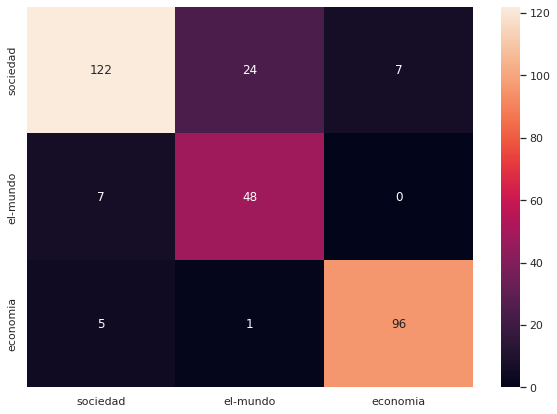

In [107]:
# Grafica de matriz de confusion
df_cm = pd.DataFrame(cnf_matrix, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [108]:
# Accuracy
accuracy_score(y_test, y_pred)

0.8580645161290322

In [109]:
# Precision
precision_score(y_test, y_pred, average='weighted')

0.8726801683528354

In [110]:
# Recall
recall_score(y_test, y_pred, average='weighted')

0.8580645161290322

In [113]:
# F1 Score
f1_score(y_test, y_pred, average='weighted')

0.8608334269978646